**Łukasz Folwarczyk**

*"Badanie i implementacja algorytmów detekcji drogi przy wykorzystaniu cyfrowego przetwarzania obrazów."*

---

# Merge hdf5 files


Notatnik pozwalający na połączenie istniejących zbiorów, zawierających zbiór danych uczących przedstawiające drogi parkowe (n próbek) oraz drogi miejskie (m próbek), które zapisane są w osobnych plikach (z rozszerzeniem hdf5) w jeden plik wynikowy z rozszerzeniem hdf5(n+m próbek). Zapisywane są dane potrzebne do przeprowadzenia procesu uczenia głębokiej sieci neuronowej (problem klasyfikacji oraz segmentacji). Działanie modułu opisane zostało w paragrafie 4.3.

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import PIL.Image
import math
import matplotlib.pyplot as plt
from random import randint
from math import ceil
import h5py


/home/lukasz/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
hdf5_dir = os.getcwd() + '/' + 'hdf5'                                 # katalog z plikami hdf5
    
hdf5_train_park_path = hdf5_dir + '/' + 'park_train_200_300.hdf5'     # plik hdf5 ze zbiorem danych treningowych-park
hdf5_train_miasto_path = hdf5_dir + '/' + 'miasto_train_200_300.hdf5' # plik hdf5 ze zbiorem danych treningowych-miasto

hdf5_test_park_path = hdf5_dir + '/' + 'park_test_200_300.hdf5'       # plik hdf5 ze zbiorem danych testowych-park
hdf5_test_miasto_path = hdf5_dir + '/' + 'miasto_test_200_300.hdf5'   # plik hdf5 ze zbiorem danych testowych-miasto

hdf5_eval_park_path = hdf5_dir + '/' + 'park_eval_200_300.hdf5'       # plik hdf5 ze zbiorem danych walidacyjnych-park
hdf5_eval_miasto_path = hdf5_dir + '/' + 'miasto_eval_200_300.hdf5'   # plik hdf5 ze zbiorem danych walidacyjnych-miasto

out_path = hdf5_dir + '/merge_out/'                                   # nazwa katalogu wyjściowego
if not os.path.exists(out_path):                                      # stworzenie katalogu wyjściowego (jeśli nie istnieje)
    os.mkdir(out_path) 

hdf5_train_miasto_park_out_path = out_path + 'miasto_park_train_merge_200_300.hdf5' # plik hdf5 ze zbiorem danych treningowych-park+miasto 
hdf5_eval_miasto_park_out_path = out_path + 'miasto_park_eval_merge_200_300.hdf5'   # plik hdf5 ze zbiorem danych testowych-park+miasto
hdf5_test_miasto_park_out_path = out_path + 'miasto_park_test_merge_200_300.hdf5'   # plik hdf5 ze zbiorem danych walidacyjnych-park+miasto

In [3]:
def merge_hdf5_files(out_filename, input_files):
    """ 
    Opis:
    ---
    Funkcja pobiera jako argumenty nazwy plików, w których zapisane 
    sa próbki uczące (zdjęcie+etykieta)ze zbioru dróg miejskich oraz parkowych. 
    Funkcja łączy dwa zbiory i zapisuje w jednym pliku wynikowym.
    Funkcja zwraca ilość zapisanych próbek w zbiorze połączonym.
    
    
    Argumenty:
    ---
        out_filename (string):  nazwa wynikowego pliku hdf5, 
                                zawierającego połączony 
                                zbiór park+miasto
        
        input_files (tuple):    nazwy plików hdf5 dla zbioru zdjęć 
                                parkowych oraz zbioru zdjęć miejskich
                                (pliki zostaną połączone w jeden wynikowy)
    Return:
    ---
        imgs_in_dataset (int):  ilość próbek w zbiorze połączonym
    """
    imgs_in_dataset = 0
    imgs_shapes = []
    labels_shapes = []
    heights = []
    widths = []
    classess = []
    
    # odczytanie plików wejściowych i ich wczytanie do zmiennych lokalnych funkcji
    for i in range(len(input_files)):                                    
        with h5py.File(input_files[i]) as hdf_file_read:                     # otwarcie pliku
            imgs_shapes.append(tuple((hdf_file_read['imgs'].shape[1:])))     # odczytanie rozmiaru zdjęć
            labels_shapes.append(tuple((hdf_file_read['labels'].shape[1:]))) # odczytanie rozmiaru etykiet zdjęć
            heights.append(hdf_file_read['height'][0, ...])                  # odczytanie wysokości zdjęć
            widths.append(hdf_file_read['width'][0, ...])                    # odczytanie szerokości zdjęć
            classess.append(hdf_file_read['classes'][0, ...])                # odczytanie ilości klas występujących w etykiecie (np. droga, tło = 2 klasy)
            imgs_in_dataset += hdf_file_read['imgs'].shape[0]                # odczytanie ilości próbek występujących w pliku

            
    # zapisane w plikach zdjęcia i ich etykiety muszą posiadać identyczny rozmiar       
    assert(len(set(imgs_shapes)) <= 1)  
    assert(len(set(labels_shapes)) <= 1)
    assert(len(set(heights)) <= 1)
    assert(len(set(widths)) <= 1)
    assert(len(set(classess)) <= 1)
    
    
    output_shape_img = (imgs_in_dataset,) + imgs_shapes[0]                   # wymiar obrazów (ilość próbek, wysokosć, szerokość, 3)
    output_shape_labels = (imgs_in_dataset,) + labels_shapes[0]              # wymiar etykiet (ilość próbek, wysokosć * szerokość, liczba klas)
    
    
    # stworzenie nowego, wynikowego pliku hdf5 i zapisanie w nim danych z plików wejściowych
    with h5py.File(out_filename) as new_hdf5_file:
        new_hdf5_file.create_dataset("imgs", output_shape_img, np.uint8)
        new_hdf5_file.create_dataset("labels", output_shape_labels, np.uint8)  
        new_hdf5_file.create_dataset("width", (1,), np.int16)
        new_hdf5_file.create_dataset("height", (1,), np.int16)
        new_hdf5_file.create_dataset("classes", (1,), np.int8)
        new_hdf5_file.create_dataset("class", (imgs_in_dataset,), np.int8)
        
        imgs_in_new_file = 0
        for i in range(len(input_files)):
            with h5py.File(input_files[i]) as hdf_file_read:
                imgs_in_file = hdf_file_read['imgs'].shape[0]
                new_hdf5_file["imgs"][imgs_in_new_file:imgs_in_new_file+imgs_in_file, ...] = (hdf_file_read["imgs"][0:imgs_in_file, ...])
                new_hdf5_file["labels"][imgs_in_new_file:imgs_in_new_file+imgs_in_file, ...] = (hdf_file_read["labels"][0:imgs_in_file, ...])
                new_hdf5_file["width"][...] = hdf_file_read['width'][0, ...]
                new_hdf5_file["height"][...] = hdf_file_read['height'][0, ...]
                new_hdf5_file["classes"][...] = hdf_file_read['classes'][0, ...]
                new_hdf5_file["class"][imgs_in_new_file:imgs_in_new_file+imgs_in_file] = i+1
                imgs_in_new_file += imgs_in_file

    return imgs_in_dataset

In [4]:
def display_img_batch(hdf5_filename, 
                      dataset_img, 
                      dataset_label, 
                      one_hot, 
                      batch_size, 
                      class_index):  
    """ 
    Opis:
    ---
    Funkcja wyświetla przykładowe obrazy oraz ich etykiety, 
    zapisane w pliku z rozszerzeniem hdf5.
    
    Argumenty:
    ---
        hdf5_filename (string):   nazwa pliku wynikowego
        
        dataset_img (string):     nazwa zbioru pliku hdf5, 
                                  w którym zapisane sa obrazy
        
        dataset_label (string):   nazwa zbioru pliku hdf5, 
                                  w którym zapisane sa etykiety
        
        one_hot (boolean):        kodowanie gorąco-jedynkowe
                                                                  
        batch_size (int):         ilosć wyświetlonych próbek
        
        class_index (int):        numer klasy wyróżnionej na zdjęciu
    
    Return:
    ---
        None
    """
    
    with h5py.File(hdf5_filename) as hdf_file_read:                  # otwarcie pliku hdf5
        height = hdf_file_read["height"][0, ...]                     # odczytanie wysokosci obrazów/etykiet
        width = hdf_file_read["width"][0, ...]                       # odczytanie szerokoci obrazów/etykiet
        cls =  hdf_file_read["classes"][0, ...]                      # odczytanie ilości klas w etykietach
        dataset_len = hdf_file_read[dataset_img].shape[0]            # odczytanie ilości par obraz/etykieta
        
        # wyświetlenie par obraz/etykieta (ilość zależna od parametru batch_size)
        for i in range(batch_size):
            # zostaje wyświetlona losowa para
            rand = randint(0, dataset_len)
            
            # odtworzenie obrazu / etykiety
            reconstructed_img = (hdf_file_read[dataset_img][rand:min(rand+1,dataset_len), ...])
            reconstructed_img = reconstructed_img[0,:,:,:]
            img_shape = reconstructed_img.shape
            reconstructed_label = (hdf_file_read[dataset_label][rand:min(rand+1,dataset_len), ...])
            
            # przetworzenie etykiety w zalezności od kodowania
            if one_hot:
                reconstructed_label = reconstructed_label[0,:,:]
                label_shape = reconstructed_label.shape
                reconstructed_label = reconstructed_label.reshape(height,width,cls)
            else:
                reconstructed_label = reconstructed_label[0,:,:,:]
                label_shape = reconstructed_label.shape
             
            # wyświetlenie pary obraz/etykieta
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(reconstructed_img)
            fig.add_subplot(1, 2, 2)
            plt.imshow(reconstructed_label[:,:,class_index])
    print("---------------------------".format(dataset_len))
    print("Ilość obrazów w zbiorze: {}".format(dataset_len))
    print("Kształt obrazów: {}".format(img_shape))
    print("Kształt etykiet: {}".format(label_shape))

# Przykad

In [5]:
# usunięcie istniejących plików wynikowych (jesli istnieja) - pliki hdf5 nie mogą być nadpisywane
files_in_out_dir = [ f for f in os.listdir(out_path) ]
for f in files_in_out_dir:
    os.remove(os.path.join(out_path, f))

In [6]:
# stworzenie pliku zawierającego połączony zbiór treningowy
temp = merge_hdf5_files(hdf5_train_miasto_park_out_path, (hdf5_train_park_path, hdf5_train_miasto_path))
# stworzenie pliku zawierającego połączony zbiór walidacyjny
temp = merge_hdf5_files(hdf5_eval_miasto_park_out_path, (hdf5_eval_park_path, hdf5_eval_miasto_path))
# stworzenie pliku zawierającego połączony zbiór testowy
temp = merge_hdf5_files(hdf5_test_miasto_park_out_path, (hdf5_test_park_path, hdf5_test_miasto_path))

---------------------------
Ilość obrazów w zbiorze: 980
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


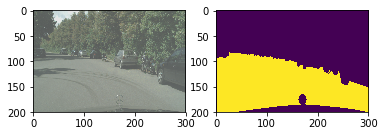

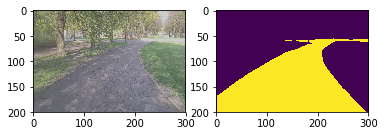

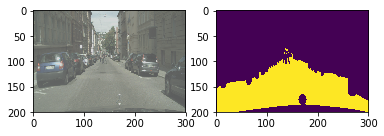

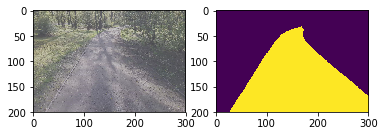

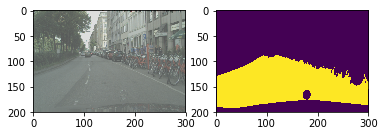

In [7]:
# wyświetlenie przykłądowych próbek zapisanych w zbiorze treningowym
display_img_batch(hdf5_train_miasto_park_out_path, 
                  "imgs", 
                  "labels", 
                  batch_size = 5,
                  one_hot = True,
                  class_index = 0)

---------------------------
Ilość obrazów w zbiorze: 280
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


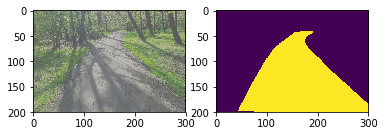

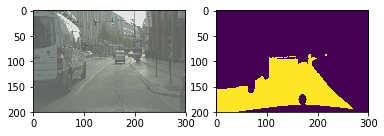

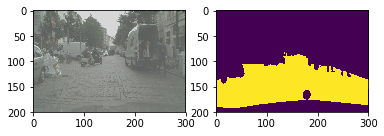

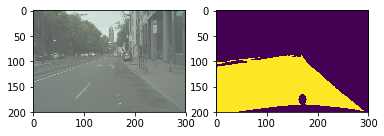

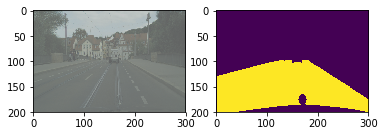

In [8]:
# wyświetlenie przykłądowych próbek zapisanych w zbiorze testowym
display_img_batch(hdf5_test_miasto_park_out_path, 
                  "imgs", 
                  "labels", 
                  batch_size = 5,
                  one_hot = True,
                  class_index = 0)

---------------------------
Ilość obrazów w zbiorze: 140
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


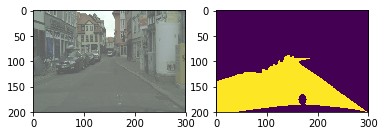

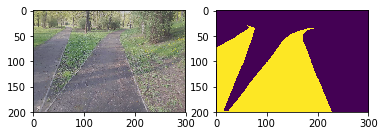

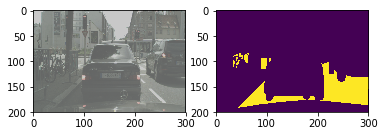

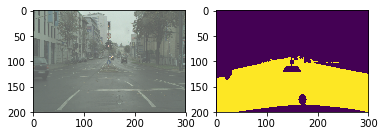

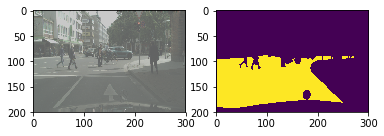

In [9]:
# wyświetlenie przykłądowych próbek zapisanych w zbiorze walidacyjnym
display_img_batch(hdf5_eval_miasto_park_out_path, 
                  "imgs", 
                  "labels", 
                  batch_size = 5,
                  one_hot = True,
                  class_index = 0)